In [146]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import os

from f_extract_buried_points import extract_buried_points
from f_extract_surface_patch import *
from f_visualize_pointcloud import visualize_pointcloud
from f_create_ang_rad_bins import create_ang_rad_bins
from f_useful_functions import *
from f_compare_patches import *

### Import the data generated by MaSIF-site

In [147]:
os.chdir('c:\\Users\\david\\MT_code\\masif_site_outputs')

In [148]:
# Import the coordinates and the features that have been generated by dMaSIF-site of the following proteins
#   - Subunit A (IgG Fc)
#   - Subunit C (GB1 protein)
#   - Complex (Subunit A and C combined)

coords_A = np.load("1fcc_A_predcoords.npy")
features_A = np.load("1fcc_A_predfeatures_emb1.npy")
features_A = features_A[:, 16:32]

coords_C = np.load("1fcc_C_predcoords.npy")
features_C = np.load("1fcc_C_predfeatures_emb1.npy")
features_C = features_C[:, 16:32]

coords_complex = np.load("1fcc_A, C_predcoords.npy")
features_complex = np.load("1fcc_A, C_predfeatures_emb1.npy")

In [149]:
# Normalize features
features_A = normalize_m11(features_A)
features_C = normalize_m11(features_C)

### Compute Buried Surface of Both Proteins

In [150]:
#buried_A, buried_A_center = extract_buried_points(coords_A, coords_complex, 2)
#buried_C, buried_C_center = extract_buried_points(coords_C, coords_complex, 2)
#print(buried_A_center, buried_C_center)

os.chdir('c:\\Users\\david\\MT_code\\extracted_patches')
#np.save("buried_A_coords.npy", buried_A)
#np.save("buried_C_coords.npy", buried_C)

### Select Center for Patch Extraction

In [151]:
center_A = 4419 #buried_A_center
center_C =  446 #random.randint(0, len(coords_C))
print(center_A, center_C)

4419 446


In [152]:
blue = [0, 0.5, 1]
red = [1, 0, 0]
green = [0, 1, 0]

colors_A = np.zeros_like(coords_A)
colors_A[:] = blue
#colors_A[buried_A] = red
colors_A[center_A] = green

#visualize_pointcloud(coords_A, colors = colors_A)

colors_C = np.zeros_like(coords_C)
colors_C[:] = blue
#colors_C[buried_C] = red
colors_C[center_C] = green

#visualize_pointcloud(coords_C, colors = colors_C)

### Extract a patch of fixed geodesic radius from the center of the buried surfaces of both proteins

In [153]:
#patch_indeces, patch_coords, pairwise_distances, first_sel, second_sel = extract_surface_patch(coords_A, center_A, 12) #REMOVE FIRST SEL Here
#patch_A = {}
#patch_A["indeces"] = patch_indeces
#patch_A["coords"] = patch_coords
#patch_A["distance_matrix"] = pairwise_distances
#patch_A["features"]=features_A[patch_A["indeces"]]
#patch_A["first_sel"]=first_sel
#patch_A["second_sel"]=second_sel
#print(len(patch_coords), len(first_sel), len(second_sel))

In [154]:
patch_indeces, patch_coords, pairwise_distances, first_sel, second_sel = extract_surface_patch(coords_C, center_C, 12)
patch_C = {}
patch_C["indeces"] = patch_indeces
patch_C["coords"] = patch_coords
patch_C["distance_matrix"] = pairwise_distances
patch_C["features"]=features_C[patch_C["indeces"]]
patch_C["first_sel"]=first_sel
patch_C["second_sel"]=second_sel
print(len(patch_coords), len(first_sel), len(second_sel))

Graph Generation: 1.1475460529327393s
Distances from center: 0.15866541862487793s
Extraction of patch members: 0.0s
Add nearest neighbors to second_sel: 0.3676121234893799s
Generation of Patch Graph: 0.3720839023590088s
Pairwise Dist Dict 71.83573341369629s
Pairwise Distance Matrix: 4.282048463821411s
671 1255 932


In [155]:
#np.save('chain_A_patch_4419.npy', patch_A)
np.save('chain_C_patch_' + str(center_C) + '.npy', patch_C)

In [156]:
patch_A = np.load('chain_A_patch_4419.npy', allow_pickle="TRUE").item()
#patch_C = np.load('chain_C_patch_6820.npy', allow_pickle="TRUE").item()

In [157]:
colors_A[patch_A["indeces"]]= green
#visualize_pointcloud(coords_A, colors = colors_A)

colors_C[patch_C["indeces"]]= green
#visualize_pointcloud(coords_C, colors = colors_C)

### Embedding in 2D with MDS

In [158]:
#Using the Geodesic Distances

mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding_A = mds.fit_transform(patch_A["distance_matrix"])
embedding_C = mds.fit_transform(patch_C["distance_matrix"])

In [159]:
# Center the alignment around the mean? Cut off points?

Text(0.5, 1.0, 'Embedding of Patch from chain C')

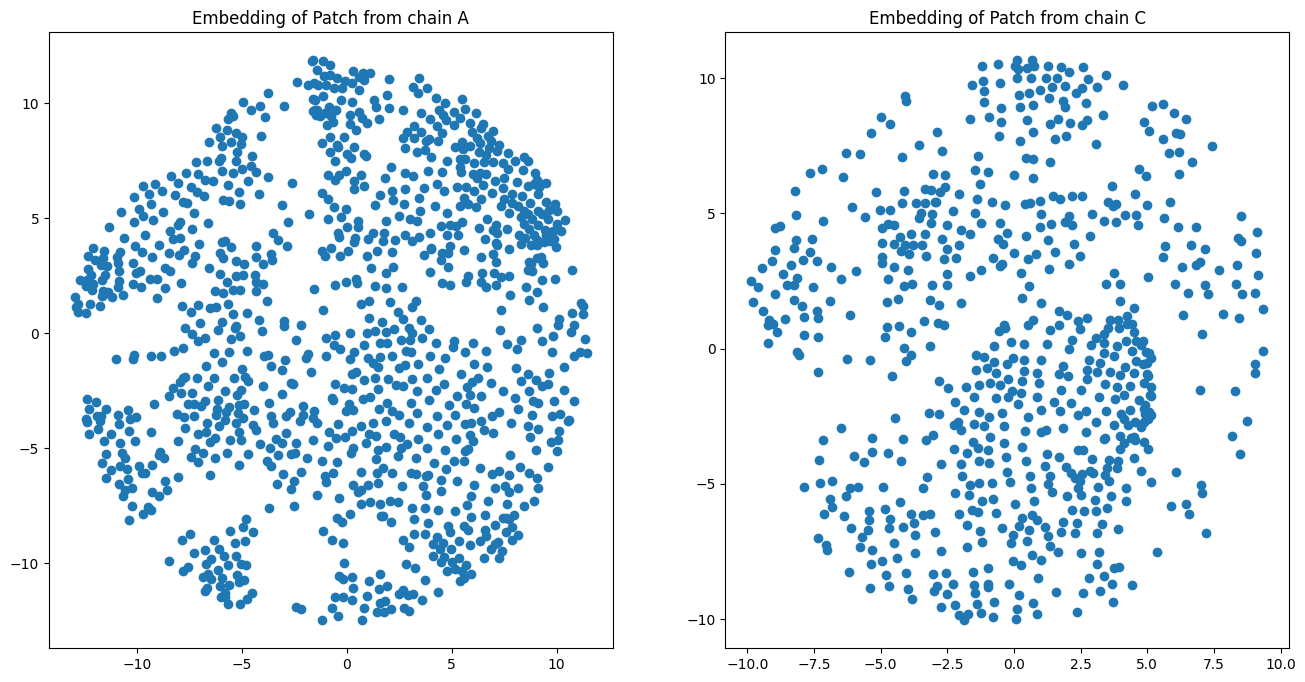

In [160]:
fig, ax = plt.subplots(2, 2, figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(embedding_A[:,0], embedding_A[:,1])
plt.title("Embedding of Patch from chain A")

plt.subplot(1,2,2)

plt.scatter(embedding_C[:,0], embedding_C[:,1])
plt.title("Embedding of Patch from chain C")

### Visualize the patch within the points of first_sel

In [161]:
colors_A_test = np.zeros_like(coords_A[patch_A["first_sel"]])
colors_A_test[:] = blue
to_make_red = patch_A["indeces"]
for ind, member in enumerate(patch_A["first_sel"]):
    if member in to_make_red:
        colors_A_test[ind]=red

#visualize_pointcloud(coords_A[patch_A["first_sel"]], colors = colors_A_test)


In [162]:
colors_A_test = np.zeros_like(coords_A[patch_A["second_sel"]])
colors_A_test[:] = blue
to_make_red = patch_A["indeces"]
for ind, member in enumerate(patch_A["second_sel"]):
    if member in to_make_red:
        colors_A_test[ind]=red

#visualize_pointcloud(coords_A[patch_A["second_sel"]], colors = colors_A_test)


### Visualize the patch within the points of second_sel

In [163]:
colors_C_test = np.zeros_like(coords_C[patch_C["first_sel"]])
colors_C_test[:] = blue
to_make_red = patch_C["indeces"]
for ind, member in enumerate(patch_C["first_sel"]):
    if member in to_make_red:
        colors_C_test[ind]=red

#visualize_pointcloud(coords_C[patch_C["first_sel"]], colors = colors_C_test)


In [164]:
colors_C_test = np.zeros_like(coords_C[patch_C["second_sel"]])
colors_C_test[:] = blue
to_make_red = patch_C["indeces"]
for ind, member in enumerate(patch_C["second_sel"]):
    if member in to_make_red:
        colors_C_test[ind]=red

#visualize_pointcloud(coords_C[patch_C["second_sel"]], colors = colors_C_test)


### Save the features of the two patches in arrays

In [165]:
features_patch_A = patch_A["features"]
features_patch_C = patch_C["features"]

Text(0.5, 1.0, 'Embedding of Patch from chain C')

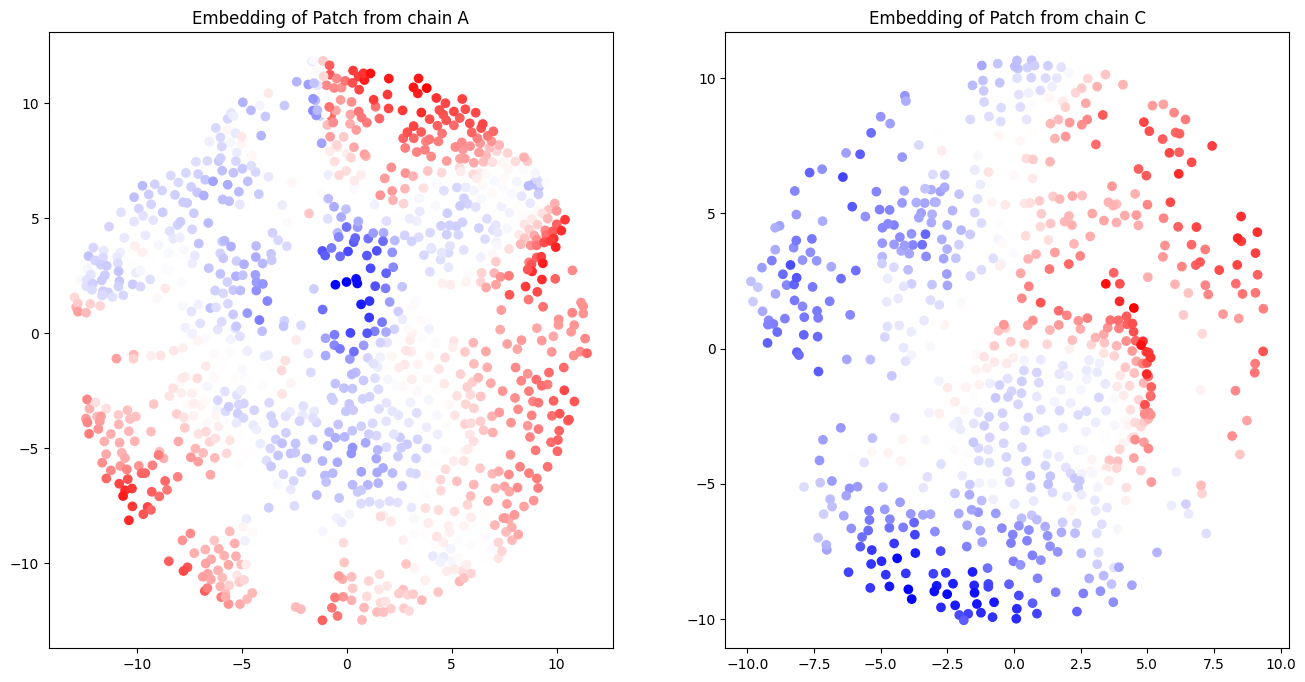

In [166]:
feature = 15

fig, ax = plt.subplots(2, 2, figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(embedding_A[:,0], embedding_A[:,1], c = features_patch_A[:,feature], cmap = "bwr")
plt.title("Embedding of Patch from chain A")

plt.subplot(1,2,2)
plt.scatter(embedding_C[:,0], embedding_C[:,1], c = features_patch_C[:,feature], cmap = "bwr")
plt.title("Embedding of Patch from chain C")


### Convert to Polar Coordinates

In [167]:
polar_coords_A = cart_to_polar(embedding_A)
polar_coords_C = cart_to_polar(embedding_C)

Text(0.5, 1.0, 'Embedding of Patch from chain C in polar coordinates')

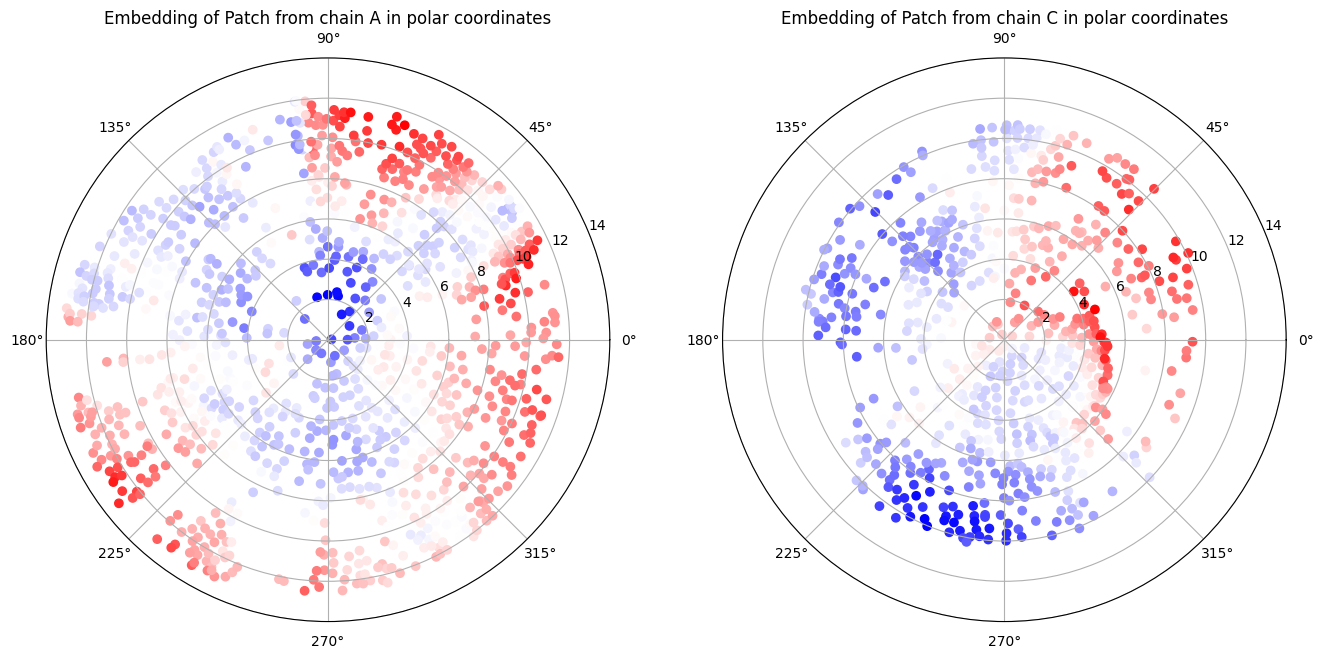

In [168]:
max_rho = 12

fig = plt.figure(figsize=(16,8))
A = fig.add_subplot(121, projection='polar')
plot1 = A.scatter(polar_coords_A[:,1], polar_coords_A[:,0], c = features_patch_A[:,feature], cmap = "bwr")
A.set_ylim([0, max_rho+2])
plt.title("Embedding of Patch from chain A in polar coordinates")

C= fig.add_subplot(122, projection='polar')
plot2 = C.scatter(polar_coords_C[:,1], polar_coords_C[:,0], c = features_patch_C[:,feature], cmap = "bwr")
C.set_ylim([0, max_rho+2])
plt.title("Embedding of Patch from chain C in polar coordinates")

In [169]:
# Center the alignment around the mean? Cut off points?

### Translate the Embedding into radial and angular bins to create array of fixed dimension

In [170]:
# Set the number of radial and angular bins and how many of its nearest neighbors should be taken into 
# account for the calculation of each bins feature vector

max_rho = 12

n_angular_bins = 72
n_radial_bins = 10
n_neighbors = 3

# Create a feature vector (length 16) for each of the bins and save them in a np.array of shape (angular bins x radial bins x features)
tensor_A = create_ang_rad_bins(n_angular_bins, n_radial_bins, max_rho, features_patch_A, embedding_A, n_neighbors) # polar_coords_A, 
tensor_C = create_ang_rad_bins(n_angular_bins, n_radial_bins, max_rho, features_patch_C, embedding_C, n_neighbors) # polar_coords_C

C:\Users\david\AppData\Local\Temp\ipykernel_9656\1923501319.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.pcolormesh(angular_A, radial_A, col_A, cmap = "bwr")
C:\Users\david\AppData\Local\Temp\ipykernel_9656\1923501319.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.pcolormesh(angular_C, radial_C, col_C, cmap = "bwr")


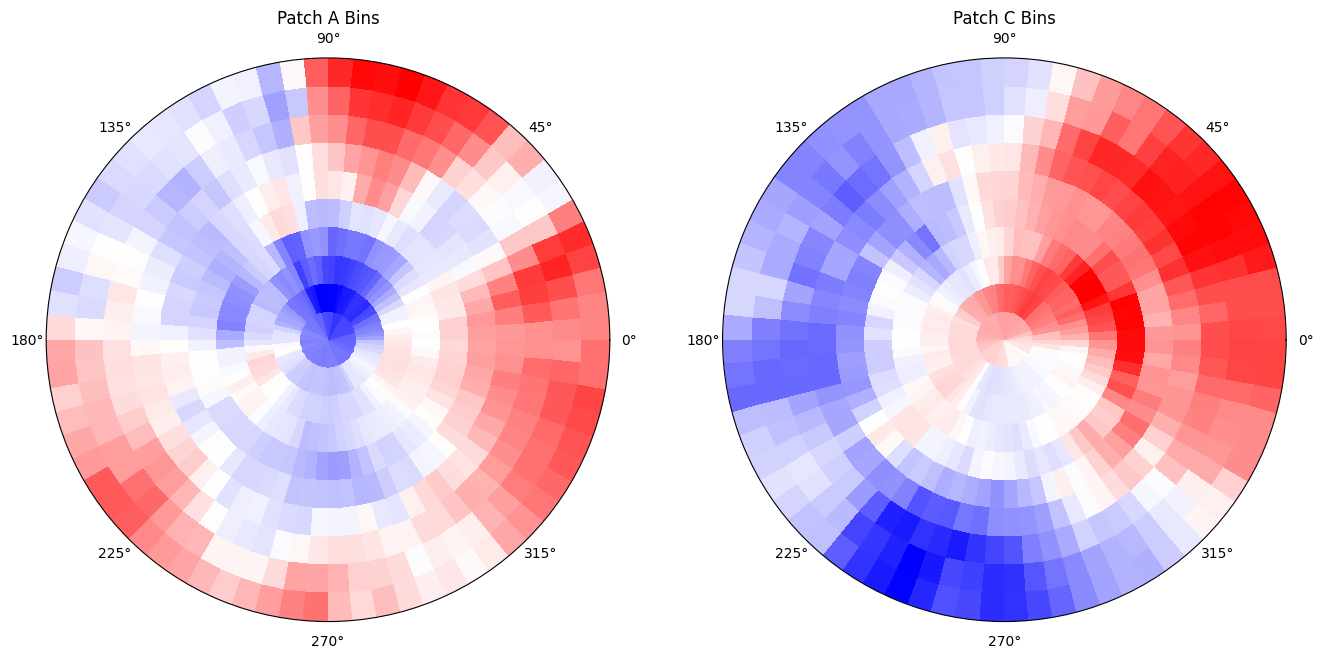

In [171]:
# Create meshgrid for plotting the two patches in bins
max_rho_A = 12# np.max(polar_coords_A[:,0]) # Determine the highest radial coordinate of any point in the patch
angular_A, radial_A = np.mgrid[-np.pi:np.pi:complex(n_angular_bins+1), 0:max_rho_A:complex(n_radial_bins+1)]

max_rho_C = 12 #np.max(polar_coords_C[:,0]) # Determine the highest radial coordinate of any point in the patch
angular_C, radial_C = np.mgrid[-np.pi:np.pi:complex(n_angular_bins+1), 0:max_rho_C:complex(n_radial_bins+1)]

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'), figsize=(16,8))

# Patch_A
col_A = tensor_A[:,:, feature] # Select the values of the feature chosen to display as color
ax1.pcolormesh(angular_A, radial_A, col_A, cmap = "bwr")
ax1.set_title('Patch A Bins')
ax1.set_ylim([0, max_rho_A])
ax1.set_yticklabels([])

# Patch_C
col_C = tensor_C[:,:, feature] # Select the values of the feature chosen to display
ax2.pcolormesh(angular_C, radial_C, col_C, cmap = "bwr")
ax2.set_title('Patch C Bins')
ax2.set_ylim([0, max_rho_C])
ax2.set_yticklabels([])

plt.show()

### Compare the two patches in all possible orientations

In [172]:
best_score, best_rotation, best_tensor2, best_dot_matrix = compare_patches(tensor_A, tensor_C, max_rho)

Initial score: 357
Rotation: 1, Score: 358.0979954085122
Rotation: 2, Score: 357.8872490176708
Rotation: 3, Score: 357.3883045849816
Rotation: 4, Score: 356.7331715249851
Rotation: 5, Score: 356.0321336666465
Rotation: 6, Score: 355.434881784652
Rotation: 7, Score: 355.02714936648636
Rotation: 8, Score: 354.62190308169465
Rotation: 9, Score: 353.9567832907223
Rotation: 10, Score: 352.8229155762539
Rotation: 11, Score: 351.26610217204876
Rotation: 12, Score: 349.8371003263552
Rotation: 13, Score: 348.7344712437747
Rotation: 14, Score: 347.82391538313914
Rotation: 15, Score: 346.98063770483134
Rotation: 16, Score: 346.1926295208454
Rotation: 17, Score: 345.3507008469393
Rotation: 18, Score: 344.639035263015
Rotation: 19, Score: 344.13380023265825
Rotation: 20, Score: 343.82764336226177
Rotation: 21, Score: 343.69773731355315
Rotation: 22, Score: 343.75925078682553
Rotation: 23, Score: 343.899903953586
Rotation: 24, Score: 343.95435096126744
Rotation: 25, Score: 343.9199978440639
Rotation

In [173]:
# Normalization of Features between -1 and 1 (whole features table)
'''
chain_C_patch_6820.npy     Best Score: 436 after 55 rotations

chain_C_patch_6509.npy     Best Score: 507 after 28 rotations
chain_C_patch_5237.npy     Best Score: 425 after 32 rotations
chain_C_patch_3200.npy     Best Score: 639 after 29 rotations
chain_C_patch_1888.npy     Best Score: 422 after 7 rotations
chain_C_patch_1291.npy     Best Score: 542 after 60 rotations
chain_C_patch_446.npy      Best Score: 358 after 66 rotations
'''

#Without Normalization of Features
'''
chain_C_patch_6820.npy     Best Score: 7014 after 55 rotations

chain_C_patch_6509.npy     Best Score: 9002 after 28 rotations
chain_C_patch_5237.npy     Best Score: 6709 after 32 rotations
chain_C_patch_3200.npy     Best Score: 12103 after 29 rotations
chain_C_patch_1888.npy     Best Score: 6266 after 7 rotations
chain_C_patch_1291.npy     Best Score: 9530 after 60 rotations
chain_C_patch_446.npy      Best Score: 4830 after 66 rotations
'''

'''
Normalization of Features between -1 and 1 (column-wise). This does not work, it "falsifies" the results

chain_C_patch_6820.npy     Best Score: 184 after 55 rotations

chain_C_patch_6509.npy     Best Score: 202 after 28 rotations
chain_C_patch_5237.npy     Best Score: 301 after 32 rotations
chain_C_patch_3200.npy     Best Score: 35 after 14 rotations
chain_C_patch_1888.npy     Best Score: 359 after 7 rotations
chain_C_patch_1291.npy     Best Score: 205 after 60 rotations
chain_C_patch_446.npy      Best Score: 345 after 66 rotations
'''
'''
Normalization of Features between 0 and 1 (column-wise) This does not work, it "falsifies" the results

chain_C_patch_6820.npy     Best Score: 2116 after 55 rotations

chain_C_patch_6509.npy     Best Score: 2085 after 28 rotations
chain_C_patch_5237.npy     Best Score: 2155 after 32 rotations
chain_C_patch_3200.npy     Best Score: 1871 after 14 rotations
chain_C_patch_1888.npy     Best Score: 2114 after 7 rotations
chain_C_patch_1291.npy     Best Score: 1900 after 60 rotations
chain_C_patch_446.npy      Best Score: 2100 after 66 rotations
'''

'\nchain_C_patch_6820.npy     Best Score: 2116 after 55 rotations\n\nchain_C_patch_6509.npy     Best Score: 2085 after 28 rotations\nchain_C_patch_5237.npy     Best Score: 2155 after 32 rotations\nchain_C_patch_3200.npy     Best Score: 1871 after 14 rotations\nchain_C_patch_1888.npy     Best Score: 2114 after 7 rotations\nchain_C_patch_1291.npy     Best Score: 1900 after 60 rotations\nchain_C_patch_446.npy      Best Score: 2100 after 66 rotations\n'

C:\Users\david\AppData\Local\Temp\ipykernel_9656\1073068791.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(angular_A, radial_A, col_A, cmap = "bwr")
C:\Users\david\AppData\Local\Temp\ipykernel_9656\1073068791.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(angular_C, radial_C, col_Cr, cmap = "bwr")
C:\Users\david\AppData\Local\Temp\ipykernel_9656\1073068791.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(angular_C, radial_C, col_C, cmap = "bwr")


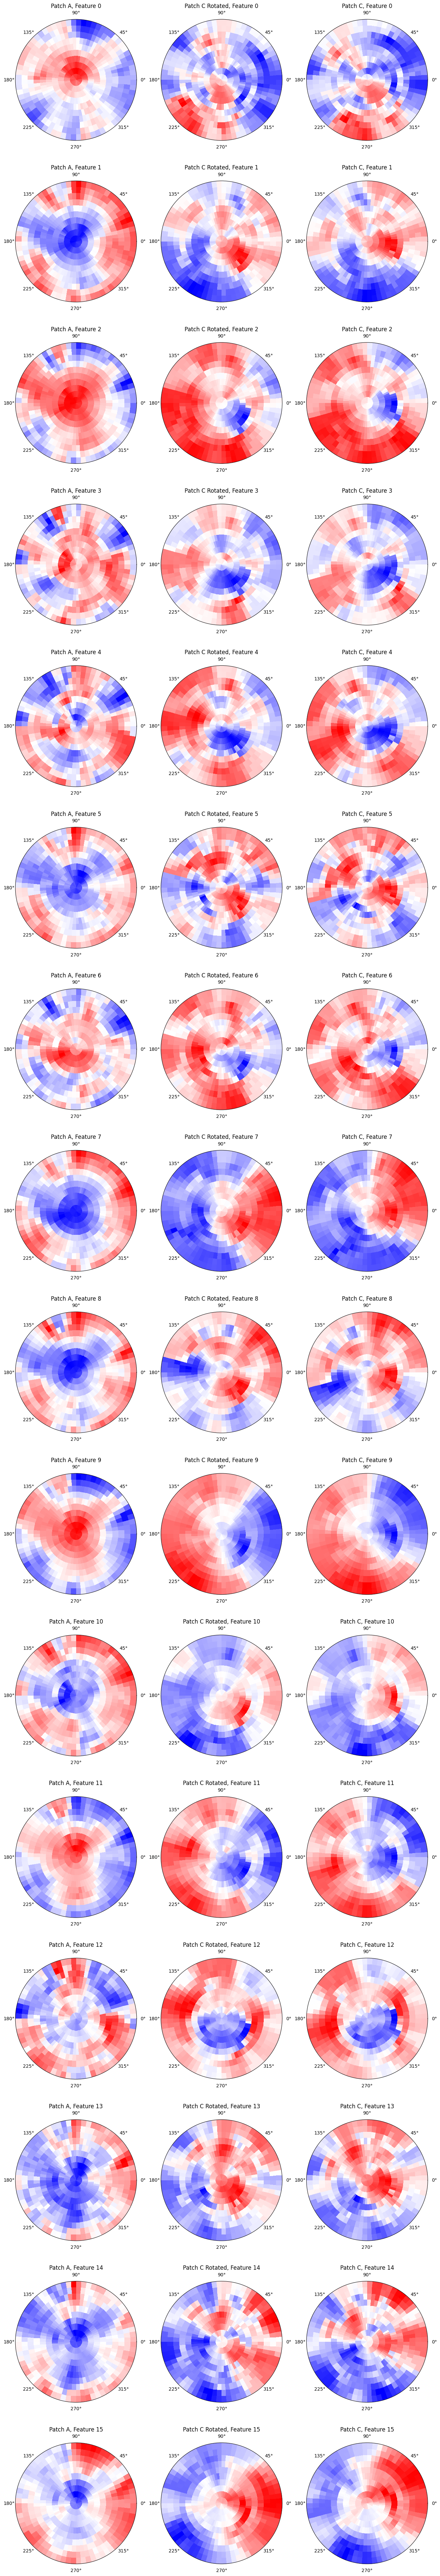

In [174]:
#  Plot

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12),
      (ax13, ax14, ax15), (ax16, ax17, ax18), (ax19, ax20, ax21), (ax22, ax23, ax24),
      (ax25, ax26, ax27), (ax28, ax29, ax30), (ax31, ax32, ax33), (ax34, ax35, ax36),
      (ax37, ax38, ax39), (ax40, ax41, ax42), (ax43, ax44, ax45), (ax46, ax47, ax48)) = plt.subplots(nrows=16, ncols=3 ,subplot_kw=dict(projection='polar'), figsize=(16,100))


for feature, i in enumerate([(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12),
      (ax13, ax14, ax15), (ax16, ax17, ax18), (ax19, ax20, ax21), (ax22, ax23, ax24),
      (ax25, ax26, ax27), (ax28, ax29, ax30), (ax31, ax32, ax33), (ax34, ax35, ax36),
      (ax37, ax38, ax39), (ax40, ax41, ax42), (ax43, ax44, ax45), (ax46, ax47, ax48)]):
      
      ax = i[0] 

      # Patch A unrotated
      col_A = tensor_A[:,:, feature] # Select the values of the feature chosen to display as color
      ax.pcolormesh(angular_A, radial_A, col_A, cmap = "bwr")
      ax.set_title('Patch A, Feature '+str(feature))
      ax.set_ylim([0, max_rho_A])
      ax.set_yticklabels([])

      ax=i[1]
      # Patch C unrotated
      col_Cr = best_tensor2[:,:, feature] # Select the values of the feature chosen to display
      ax.pcolormesh(angular_C, radial_C, col_Cr, cmap = "bwr")
      ax.set_title('Patch C Rotated, Feature '+str(feature))
      ax.set_ylim([0, max_rho_C])
      ax.set_yticklabels([])

      ax=i[2]
      # Patch C rotated
      col_C = tensor_C[:,:, feature] # Select the values of the feature chosen to display
      ax.pcolormesh(angular_C, radial_C, col_C, cmap = "bwr")
      ax.set_title('Patch C, Feature '+str(feature))
      ax.set_ylim([0, max_rho_C])
      ax.set_yticklabels([])

plt.show()
